# Correcting Donelan et al. (2004) data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import warnings
warnings.filterwarnings("ignore")

## Plot original Fig. 2

This section reproduces the original Fig. 2 of Donelan et al. (2004). Note that this plots the uncorrected data.

### Load the data

In [2]:
# Reynolds stress (hot film)
mat = loadmat('data/donelan_etal_2004/uwcd.mat')
U10_hf, CD_hf = mat['U10uw'][0], mat['cduw'][0]

# Momentum budget
mat = loadmat('data/donelan_etal_2004/dragplt2.mat')
U10_mb, CD_mb = mat['U10CD'][0].real, mat['CD'][0].real

# Profile method
mat = loadmat('data/donelan_etal_2004/dragplot.mat')
U10_pr, CD_pr = mat['U10'][0], mat['cd'][0]

# Profile method from Ocampo-Torres et al (1994)
ust = np.array([1.046, 1.046, 0.807, 0.644, 0.389, 0.204, 0.148,
    0.081, 0.047, 0.047, 0.048, 0.057, 0.066, 0.077, 0.281, 0.282,
    0.289, 0.289, 0.505, 0.039, 0.049, 0.053, 0.055, 0.064, 0.075,
    0.081, 0.109, 0.134, 0.170, 0.220, 0.326, 0.462, 0.619, 0.791, 0.973])
u30 = np.array([16.02, 16.02, 13.83, 12.13, 8.96, 5.83, 4.58, 2.64,
    1.01, 1.17, 1.22, 1.65, 2.06, 2.49, 7.25, 7.27, 7.4, 7.4, 10.5,
    1.05, 1.28, 1.44, 1.57, 1.98, 2.42, 2.64, 3.52, 4.24, 5.09, 6.15,
    8.01, 9.95, 11.85, 13.66, 15.38])
U10_ot94 = 2.5 * ust * np.log(1000 / 30) + u30
CD_ot94 = ust**2 / U10_ot94**2

# Dissipation method from Large and Pond (1981)
U10_lp81 = np.array([4, 10, 26])
CD_lp81 = np.array([1.14, 1.14, 2.148]) * 1e-3

### Plot the figure

Text(0.5, 1.0, 'Laboratory measured drag coefficients by various methods')

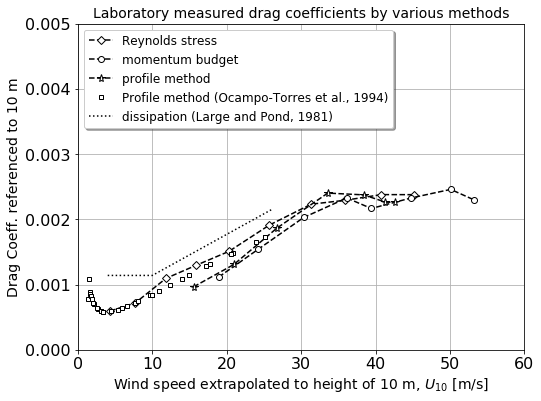

In [3]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlim=(0, 60), ylim=(0, 5e-3))
ax.tick_params(axis='both', labelsize=16)
plt.plot(U10_hf[:-2], CD_hf[:-2], 'k--', marker='D', mfc='w', ms=6, label='Reynolds stress')
plt.plot(U10_mb[4:], CD_mb[4:], 'k--', marker='o', mfc='w', ms=6, label='momentum budget')
plt.plot(U10_pr[3:10], CD_pr[3:10], 'k--', marker='*', mfc='w', ms=8, label='profile method')
plt.plot(U10_ot94, CD_ot94, 'ks', mfc='w', ms=4, label='Profile method (Ocampo-Torres et al., 1994)')
plt.plot(U10_lp81, CD_lp81, 'k:', label='dissipation (Large and Pond, 1981)')
plt.legend(loc='upper left', fancybox=True, shadow=True, prop={'size': 12})
plt.grid()
plt.xlabel(r'Wind speed extrapolated to height of 10 m, $U_{10}$ [m/s]', fontsize=14)
plt.ylabel('Drag Coeff. referenced to 10 m', fontsize=14)
plt.title('Laboratory measured drag coefficients by various methods', fontsize=14)

## Correction to Donelan et al. (2004) data

To correct the data, we will first load the original drag coefficient and $U_{10}$ data, and calculate the friction velocity:

$$
u_* = \sqrt{C_D} U_{10}
$$

We will then use the correct in situ wind speed $U_z$ to scale the wind to 10-m reference height, and compute the new drag coefficient at 10-m height:

$$
U_{10} = U_z + \dfrac{u_*}{\kappa} \log{\left(\dfrac{10}{z}\right)}
$$

$$
C_D = \left(\dfrac{u_*}{U_{10}}\right)^2
$$

In [4]:
VON_KARMAN = 0.4 # Von Karman constant

# load in situ (z = 0.3 m) wind speed data from pitot tube
# that were collected during the hot film and momentum budget runs
mat = loadmat('data/donelan_etal_2004/uwvsu2-24.mat')
u_z = mat['ups'][0]

# Reynolds stress (hot film)
ust_hf = np.sqrt(CD_hf) * U10_hf
U10_hf_corrected = u_z + ust_hf / VON_KARMAN * np.log(10 / 0.3)
CD_hf_corrected = ust_hf**2 / U10_hf_corrected**2

# Momentum budget
ust_mb = np.sqrt(CD_mb) * U10_mb
U10_mb_corrected = u_z + ust_mb / VON_KARMAN * np.log(10 / 0.3)
CD_mb_corrected = ust_mb**2 / U10_mb_corrected**2

### Load reference field data

In [5]:
e13 = np.loadtxt('data/edson_etal_2013.txt', skiprows=1)
U10_e13, CD_e13, CD_std_e13 = e13[:,0], e13[:,1], e13[:,2]

### Drag coefficient as parameterized in Advanced Hurricane WRF (Davis et al. 2008)

In [6]:
GRAV = 9.8
OZO = 1.59e-5
VON_KARMAN = 0.4


def cd_from_z0(z0, z):
    """Returns drag coefficient at height z given input roughness length z0."""
    return (VON_KARMAN / np.log(z / z0))**2


def roughness_length_wrf(ust):
    """Roughness length as function of friction velocity, 
    as parameterized in Advanced Hurricane WRF by Davis et al. (2008)"""
    ust_tmp = ust[:]
    ust_tmp[ust_tmp < 0.01] = 0.01
    Z0MIN = 1.27e-7
    Z0MAX = 2.85e-3
    zw = (ust / 1.06)**0.3
    zw[zw < 1] = 1
    zn1 = 0.011 * ust**2 / GRAV + OZO
    zn2 = 10 * np.exp(-9.5 * ust**(-0.3333) + 0.11 * 1.5e-5 / ust_tmp)
    z0 = (1 - zw) * zn1 + zw * zn2
    z0[z0 > Z0MAX] = Z0MAX
    z0[z0 < Z0MIN] = Z0MIN
    return z0

# WRF parameterization
ust_wrf = np.arange(0.001, 4.001, 0.001)
z0_wrf = roughness_length_wrf(ust_wrf)
CD_wrf = cd_from_z0(z0_wrf, 10.)
U10_wrf = ust_wrf / np.sqrt(CD_wrf)

### Plot the figure

Text(0.5, 1.0, 'Correction to Donelan et al. (2004) drag coefficient')

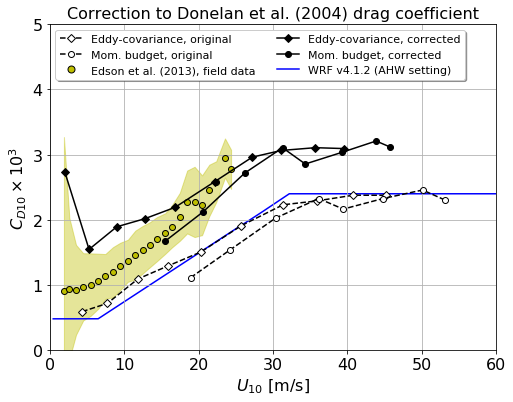

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlim=(0, 60), ylim=(0, 5))
ax.tick_params(axis='both', labelsize=16)

# Edson et al. (2013)
plt.plot(U10_e13, CD_e13, color='y', marker='o', ms=6, mec='k', linestyle='')
plt.fill_between(U10_e13, CD_e13 - CD_std_e13, CD_e13 + CD_std_e13, color='y', alpha=0.4)

plt.plot(U10_hf[:-2], 1e3 * CD_hf[:-2], 'k--', 
         marker='D', mfc='w', ms=6, label='Eddy-covariance, original', zorder=10)
plt.plot(np.real(U10_mb[4:]), 1e3 * CD_mb[4:], 'k--', 
         marker='o', mfc='w', ms=6, label='Mom. budget, original', zorder=10)

plt.plot(np.nan, np.nan, 'y.', ms=14, mec='k', label='Edson et al. (2013), field data')

plt.plot(U10_hf_corrected[:-2], 1e3 * CD_hf_corrected[:-2], 'k-', 
         marker='D', mfc='k', ms=6, label='Eddy-covariance, corrected', zorder=10)
plt.plot(np.real(U10_mb_corrected[4:]), 1e3 * CD_mb_corrected[4:], 'k-', 
         marker='o', mfc='k', ms=6, label='Mom. budget, corrected', zorder=10)

plt.plot(U10_wrf, 1e3 * CD_wrf, 'b-', label='WRF v4.1.2 (AHW setting)', zorder=1)

plt.legend(loc='upper left', fancybox=True, shadow=True, ncol=2, prop={'size': 11})
plt.grid()
plt.xlabel(r'$U_{10}$ [m/s]', fontsize=16)
plt.ylabel(r'$C_{D10} \times 10^3$', fontsize=16)
plt.title('Correction to Donelan et al. (2004) drag coefficient', fontsize=16)